Proportion of train_set : 0.37%
Proportion of valid_set : 0.13%


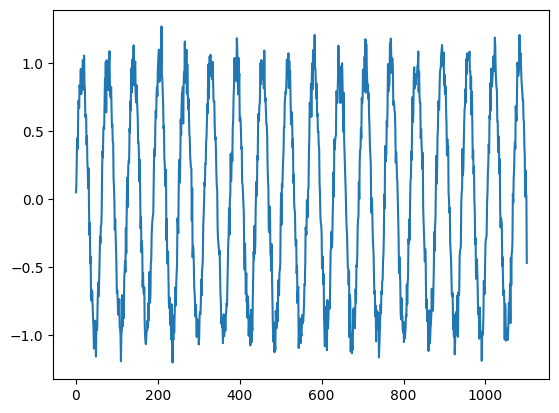

In [1]:
from experiment import Experiment
from utils.plot import plot_predictions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


solar_power = pd.read_csv('./data/solarpanelspower/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'date'}).set_index('date')
def generate_data(num_steps: int, interval: float = 0.1) -> None:
    x = np.linspace(0, num_steps * interval, num_steps)
    y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
    return y


solar_power['Elec_kW'] =generate_data(len(solar_power))


train_set = solar_power[:'2014-10-31']
valid_set = solar_power['2014-11-01':'2015-11-18']
# test_set = solar_power['2019-11-18':]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))
# print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(solar_power)))
plt.plot(train_set.Elec_kW.values)

---
#### SimpleTransformer (Medium Article)

In [2]:
import math
import time
from torch.utils.data import DataLoader
from torch import nn
import torch


# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html,
# only modified to account for "batch first".
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Adds positional encoding to the given tensor.

        Args:
            x: tensor to add PE to [bs, seq_len, embed_dim]

        Returns:
            torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, 
        num_layers, dim_feedforward
    ) -> None:
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()
        self.train_loss_history = []
        self.validation_loss_history = []
        #
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim, out_features=embed_dim)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim, out_features=embed_dim)
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)
        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            dim_feedforward=dim_feedforward,
            batch_first=True,
        )
    def is_transformer(self, ): return True

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)
        # Embed encoder input and add positional encoding [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)
        # Generate mask to avoid attention to future outputs.[tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding. [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)
        # Get prediction from transformer and map to output dimension.[bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)

        return pred

    def validate(self, data):
        val_loader = DataLoader(data, batch_size=1024, shuffle=False)
        loss_fn = nn.MSELoss()
        val_loss = 0.0
        #
        self.eval()
        with torch.no_grad():
            for enc_x, dec_x, tgt_y in val_loader:
                pred_y = self(enc_x, dec_x)
                val_loss += loss_fn(pred_y, tgt_y)
        val_loss = val_loss/len(val_loader)
        return val_loss
    
    def predict(self, src, forecast_horizon):
        self.eval()
        with torch.no_grad():
            output = torch.zeros(1, forecast_horizon + 1, 1).to('cuda')
            output[0, 0, 0] = src[0, -1] # first value
            for i in range(forecast_horizon):
                y = self(src, output)[0,i,0]
                output[0,i+1,0] = y
        return output[:,1:,:] # remove first value (copy from last history step)


    def fit(self, conf):
        expected_vars = ['epochs','lr','batch_size','train_dataset']
        for v in expected_vars:
            assert v in conf.keys(), f'Key "{v}" is missing on params dict'
        #
        epochs = conf['epochs']
        verbose = conf['verbose']
        train_dataset = conf['train_dataset']
        val_dataset = conf.get('train_dataset',None)
        #
        optimizer = torch.optim.Adam(self.parameters(), lr=conf['lr'])
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=True)
        for epoch_i in range(epochs):
            timr = time.time()
            epoch_loss = .0
            val_loss = -1
            for enc_x, dec_x, tgt_y in train_loader:
                optimizer.zero_grad() # current batch zero-out the loss
                pred_y = self(enc_x, dec_x)
                loss = loss_fn(pred_y, tgt_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss        
            # end epoch
            epoch_loss = epoch_loss/len(train_loader)
            # if there are a validation set
            if val_dataset is not None:
                val_loss = self.validate(val_dataset)
                self.validation_loss_history.append(val_loss.to('cpu').detach().numpy())
            self.train_loss_history.append(epoch_loss.to('cpu').detach().numpy())
            #     
            timr = time.time() - timr
            if verbose: 
                print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f} | Validation loss: {val_loss:.5f}')


input_len = 100
fh = 128
d_model = 128
model_params={
    'in_dim': 1, 
    'out_dim':1, 
    'embed_dim': d_model, 
    'num_heads': 8, 
    'num_layers': 2,
    'dim_feedforward':128
}
torch.cuda.empty_cache()
import gc
gc.collect()
model = TransformerWithPE(**model_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)
print(model)

Num of weights: 532097
TransformerWithPE(
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_embedding): Linear(in_features=1, out_features=128, bias=True)
  (decoder_embedding): Linear(in_features=1, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        

In [3]:
from sklearn.preprocessing import MinMaxScaler
exp = Experiment(
    {
        # Model
        'model': model,
        'input_len':input_len,
        'feature_dim':1,
        'forecast_horizon':fh,
        # Data
        'frequency':'daily',
        'scaler':None,#MinMaxScaler((-1,1)),
        'decompose': False, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })
#

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)

#
exp.train({
    'epochs':512,
    'lr':0.001,
    'batch_size':1024,
    'verbose':True,
})

Epoch 1/512 [0.893secs] -> Train loss: 0.91340 | Validation loss: 8.46183
Epoch 2/512 [0.744secs] -> Train loss: 8.46183 | Validation loss: 1.30099
Epoch 3/512 [0.732secs] -> Train loss: 1.30099 | Validation loss: 0.58352
Epoch 4/512 [0.728secs] -> Train loss: 0.58352 | Validation loss: 1.22121
Epoch 5/512 [0.789secs] -> Train loss: 1.22121 | Validation loss: 1.05001
Epoch 6/512 [0.724secs] -> Train loss: 1.05001 | Validation loss: 0.64852
Epoch 7/512 [0.721secs] -> Train loss: 0.64852 | Validation loss: 0.44185
Epoch 8/512 [0.722secs] -> Train loss: 0.44185 | Validation loss: 0.46174
Epoch 9/512 [0.723secs] -> Train loss: 0.46174 | Validation loss: 0.56264
Epoch 10/512 [0.739secs] -> Train loss: 0.56264 | Validation loss: 0.59458
Epoch 11/512 [0.733secs] -> Train loss: 0.59458 | Validation loss: 0.53867
Epoch 12/512 [0.734secs] -> Train loss: 0.53867 | Validation loss: 0.45506
Epoch 13/512 [0.737secs] -> Train loss: 0.45506 | Validation loss: 0.40236
Epoch 14/512 [0.735secs] -> Train 

In [ ]:
last_train_values = train_set.Elec_kW.values[-input_len:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh+100)
exp.print_metrics(next_validation_values, pred_y[:fh])
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

MSE: 0.7939 | MAPE: 1.9633 | sMAPE: 1.3922


---
#### SimpleTransformer (Local)

In [ ]:
# from models.transformer import TimeSeriesTransformer
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
#
from layers import PositionalEmbedding,Time2Vec

class TimeSeriesTransformer(nn.Module):
    def __init__(self, model_params: dict):
        super(TimeSeriesTransformer, self).__init__()
        # Set model vars
        expected_vars = ['in_features','d_model','input_len','max_input_len',
                         'encoder_nheads','encoder_nlayers','encoder_dropout',
                         'decoder_nheads','decoder_nlayers','decoder_dropout',
                         'feedforward_dim','forecast_horizon','seed','time_emb_dim','verbose']
        for v in expected_vars:
            assert v in model_params.keys(), f'Key "{v}" is missing on params dict'
            vars(self)[v] = model_params[v]
        #
        # Pre-configuration (to produce same result in inference/predict)
        #
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)
        #
        self.train_loss_history = []
        self.validation_loss_history = []
        #
        # Encoder layers
        #
        self.encoder_input_layer = nn.Linear(in_features=self.in_features, out_features=self.d_model)
        self.positional_encoding = Time2Vec(input_dim=self.d_model, embed_dim=self.time_emb_dim * self.d_model)#PositionalEmbedding(self.d_model, max_len=self.max_input_len)
        

        encoder_layer = nn.TransformerEncoderLayer(
                            d_model=self.d_model,
                            nhead=self.encoder_nheads,
                            dim_feedforward=self.feedforward_dim,
                            dropout=self.encoder_dropout,
                            batch_first=True)
        self.encoder_block = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=self.encoder_nlayers, norm=None)
        #
        # Decoder layers
        #
        self.decoder_input_layer = nn.Linear(in_features=self.in_features, out_features=self.d_model)
        decoder_layer = nn.TransformerDecoderLayer(
                            d_model=self.d_model, 
                            nhead=self.decoder_nheads,
                            dim_feedforward=self.feedforward_dim,
                            dropout=self.decoder_dropout,
                            batch_first=True,
                            )
        self.decoder_block = nn.TransformerDecoder(decoder_layer=decoder_layer,num_layers=self.decoder_nlayers, norm=None)
        self.decoder_dense_mapping = nn.Linear(self.d_model, self.in_features)

    def get_train_masks(self,):
        # which will mask the encoder output
        memory_mask = generate_square_subsequent_mask(self.forecast_horizon, self.input_len)
        # which will mask the decoder input
        tgt_mask = generate_square_subsequent_mask(self.forecast_horizon, self.forecast_horizon)
        return memory_mask, tgt_mask

    def encode(self, x):
        if self.verbose: print(f'#1) Encoder input shape = {x.shape}')
        
        # linear transformation (embedding)
        y = self.encoder_input_layer(x)
        
        if self.verbose: print(f'#2) Encoder embedding layer output: {y.shape}')
        
        # # positional encoding 
        y = self.positional_encoding(y)
        if self.verbose: print(f'#3) Positional encoding output: {y.shape}')

        # encoder block 
        y = self.encoder_block(y)
        if self.verbose: print(f'#4) Encoder block output: {y.shape}\n')
        return y
    
    def decode(self, x, enc_y,  memory_mask, tgt_mask):
        if self.verbose: print(f'#5) Decoder input shape = {x.shape}')
        y = self.decoder_input_layer(x)
        if self.verbose: print(f'#6) Decoder input layer output: {y.shape}')
        
        # positional encoding 
        y = self.positional_encoding(y)
        if self.verbose: print(f'#7) Positional encoding output: {y.shape}')
        
        # Pass decoder input through decoder input layer
        y = self.decoder_block(
            tgt=y,
            memory=enc_y,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask
        )
        if self.verbose: print(f'#8) Decoder block output: {y.shape}')

        # mapping (dense)
        y = self.decoder_dense_mapping(y)
        # y = self.decoder_dense_mapping2(y)
        if self.verbose: print(f'#9) Decoder mapping(dense) output: {y.shape}')

        return y

    def forward(self, enc_x, dec_x, memory_mask=None, tgt_mask=None):
        enc_y = self.encode(enc_x)
        dec_y = self.decode(dec_x, enc_y, memory_mask, tgt_mask)
        return dec_y
    
    def is_transformer(self,):
        return True
    
    def predict(self, src, forecast_horizon):
        self.eval()
        with torch.no_grad():
            output = torch.zeros(1, forecast_horizon + 1, 1).to('cuda')
            output[0, 0, 0] = src[0, -1] # first value
            for i in range(forecast_horizon):
                dim_a = output.shape[1]
                tgt_mask = generate_square_subsequent_mask(dim_a, dim_a).to('cuda')
                y = self(src, output, None, tgt_mask)[0,i,0]
                output[0,i+1,0] = y
        return output[:,1:,:] # remove first value (copy from last history step)

    def validate(self, data):
        val_loader = DataLoader(data, batch_size=1024, shuffle=False)
        loss_fn = nn.MSELoss()
        val_loss = 0.0
        #
        memory_mask, tgt_mask = self.get_train_masks()
        memory_mask, tgt_mask = memory_mask.to('cuda'), tgt_mask.to('cuda')
        self.eval()
        with torch.no_grad():
            for enc_x, dec_x, tgt_y in val_loader:
                pred_y = self(enc_x, dec_x, memory_mask, tgt_mask)
                val_loss += loss_fn(pred_y, tgt_y)
        val_loss = val_loss/len(val_loader)
        return val_loss


In [ ]:
input_len = 50 
fh = 128
d_model = 16
model_params = {
        'in_features':1, # The number of input variables. 1 if univariate forecasting.
        'input_len':input_len,
        'max_input_len':fh*10, # What's the longest sequence the model will encounter? Used to make the positional encoder
        'forecast_horizon':fh, # Length of the target sequence, i.e. how many time steps should your forecast cover
        #
        'd_model':d_model, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
        'feedforward_dim':16,
        'time_emb_dim':1,
        #
        'encoder_nheads':2, # The number of attention heads (parallel attention layers)
        'decoder_nheads':2, # The number of attention heads (parallel attention layers)
        'encoder_nlayers':2, # Number of times the layer is stacked
        'decoder_nlayers':2, # Number of times the layer is stacked
        #
        'encoder_dropout': 0, #0.1,
        'decoder_dropout': 0,# 0.1, # with zeroed dropout we can reproduce the outputs.
        'encoder_ps_dropout': 0,#0.1,
        'seed':7,
        'verbose':False,
    }
model = TimeSeriesTransformer(model_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)

Num of weights: 9137


In [ ]:

exp = Experiment(
    {
        # Model
        'model': model,
        'input_len':input_len,
        'feature_dim':1,
        'forecast_horizon':fh,
        # Data
        'frequency':'daily',
        'scaler':MinMaxScaler((-1,1)),
        'decompose': False, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })
#

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)
#
def temp_train(self, conf):
    expected_vars = ['epochs','lr','batch_size','train_dataset']
    for v in expected_vars:
        assert v in conf.keys(), f'Key "{v}" is missing on params dict'
    #
    epochs = conf['epochs']
    verbose = conf['verbose']
    train_dataset = conf['train_dataset']
    val_dataset = conf.get('train_dataset',None)
    #
    optimizer = torch.optim.Adam(self.parameters(), lr=conf['lr'])
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=True)
    memory_mask, tgt_mask = self.get_train_masks()
    memory_mask, tgt_mask = memory_mask.to('cuda'), tgt_mask.to('cuda')
    for epoch_i in range(epochs):
        timr = time.time()
        epoch_loss = .0
        val_loss = -1
        for enc_x, dec_x, tgt_y in train_loader:
            optimizer.zero_grad() # current batch zero-out the loss
            pred_y = self(enc_x, dec_x, memory_mask, tgt_mask)
            loss = loss_fn(pred_y, tgt_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss        
        # end epoch
        epoch_loss = epoch_loss/len(train_loader)
        # if there are a validation set
        if val_dataset is not None:
            val_loss = self.validate(val_dataset)
            self.validation_loss_history.append(val_loss.to('cpu').detach().numpy())
        self.train_loss_history.append(epoch_loss.to('cpu').detach().numpy())
        #     
        timr = time.time() - timr
        if verbose: 
            print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f} | Validation loss: {val_loss:.5f}')

    
exp.model.fit = lambda x: temp_train(exp.model, x)

#
exp.train({
    'epochs':1024,
    'lr':1e-2,
    'batch_size':1024,
    'verbose':True,
})

Scaler FIT
Epoch 1/1024 [0.190secs] -> Train loss: 0.97497 | Validation loss: 0.65007
Epoch 2/1024 [0.144secs] -> Train loss: 0.65007 | Validation loss: 0.52344
Epoch 3/1024 [0.138secs] -> Train loss: 0.52344 | Validation loss: 0.27900
Epoch 4/1024 [0.137secs] -> Train loss: 0.27900 | Validation loss: 0.18774
Epoch 5/1024 [0.137secs] -> Train loss: 0.18774 | Validation loss: 0.21685
Epoch 6/1024 [0.137secs] -> Train loss: 0.21685 | Validation loss: 0.26696
Epoch 7/1024 [0.136secs] -> Train loss: 0.26696 | Validation loss: 0.27692
Epoch 8/1024 [0.138secs] -> Train loss: 0.27692 | Validation loss: 0.24888
Epoch 9/1024 [0.136secs] -> Train loss: 0.24888 | Validation loss: 0.21091
Epoch 10/1024 [0.138secs] -> Train loss: 0.21091 | Validation loss: 0.18703
Epoch 11/1024 [0.138secs] -> Train loss: 0.18703 | Validation loss: 0.18544
Epoch 12/1024 [0.139secs] -> Train loss: 0.18544 | Validation loss: 0.19908
Epoch 13/1024 [0.138secs] -> Train loss: 0.19908 | Validation loss: 0.21371
Epoch 14/1

KeyboardInterrupt: 

AttributeError: 'TransformerWithPE' object has no attribute 'predict'